<a href="https://colab.research.google.com/github/dlskawns/LG_Uplus_AI_Stage/blob/main/LG_Uplus_competition_DeepFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Deep FM 실험

참고: https://greeksharifa.github.io/machine_learning/2020/04/07/DeepFM/  


In [ ]:
!pip install -r "/content/drive/MyDrive/code/requirements.txt"

In [ ]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [ ]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

# 오리지날 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [ ]:
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/buy_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/watch_e_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/search_data.csv'), encoding='utf-8')
metap_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data_plus.csv'), encoding='utf-8')

In [ ]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [ ]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [ ]:
# 초기 데이터 처리
h_df = history_df[['profile_id','log_time','album_id']]
# meta = meta_df[['album_id','genre_mid','run_time']].drop_duplicates()
df = pd.merge(h_df, profile_df[['profile_id','sex','age']], 'left', on = 'profile_id')
df = pd.merge(df, meta_df, 'left', on = 'album_id')
view_cnts = df.groupby('profile_id')['album_id'].count()
df['views'] = df['profile_id'].map(lambda x: view_cnts[x])

In [ ]:
search = search_df[['profile_id','album_id']].drop_duplicates()
search['search'] = 1

In [ ]:
df = pd.merge(df,buy_df[['profile_id','album_id','payment']].drop_duplicates(), 'left', on = ['profile_id','album_id'])
df = pd.merge(df, search[['profile_id','album_id','search']], 'left', on=['profile_id','album_id'])
df.head(3)

,profile_id,log_time,album_id,sex,age,title,sub_title,genre_large,genre_mid,genre_small,...,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,views,payment,search
0,3,20220301115719,15,F,5,거미,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
1,3,20220301115809,16,F,5,상어 가족,노래율동,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN
2,3,20220301115809,16,F,5,상어 가족,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN


In [ ]:
me = pd.merge(metap_df, meta_df[['album_id','title','genre_mid']] ,"left", on = "album_id").drop_duplicates()
me

,album_id,keyword_type,keyword_name,keyword_value,title,genre_mid
0,749,05010101,시리즈,0,어둠이 무서워요,TV만화
1,749,05010302,EBS,0,어둠이 무서워요,TV만화
2,749,05010401,3세,0,어둠이 무서워요,TV만화
3,749,05010402,4세,0,어둠이 무서워요,TV만화
4,749,05010407,1세,0,어둠이 무서워요,TV만화
...,...,...,...,...,...,...
832351,11629,05040104,신나는,0,손가락 하나,노래율동
832352,11629,0504010b,따라하고 싶은,0,손가락 하나,노래율동
832353,11629,05070e01,인체,0,손가락 하나,노래율동
832354,11629,05080401,캐릭터 친구들,0,손가락 하나,노래율동


In [ ]:
import scipy.stats as stats

cross = np.array(pd.crosstab(me['keyword_name'],me['genre_mid']))
X = stats.chi2_contingency(cross,correction= False)
X2 = X[0]
p = X[1]
n = np.sum(cross)
mindim = min(cross.shape)-1
V = np.sqrt((X2/n)/mindim)
V

0.311367385290803

크래머 v 계수가 어느정도 상관성을 띈다.  
그러므로 가장 빈도가 높은 장르 5개에 대한 키워드 빈도가 다른지 한번 보자



In [ ]:
me['genre_mid'].value_counts()[:5]

TV만화    232481
놀이교실    156211
노래율동    135862
외국어      85331
애니       38160
Name: genre_mid, dtype: int64

In [ ]:
for i in me['genre_mid'].value_counts()[:5].index:
  print(me[me['genre_mid']==i]['keyword_name'].value_counts()[:5])

시리즈       9222
사회정서      8839
엔터        8561
스토리 애니    8290
언어1       7911
Name: keyword_name, dtype: int64
시리즈       10333
사회정서       8795
언어1        8713
엔터         7870
어린이 예능     6328
Name: keyword_name, dtype: int64
음악      6550
시리즈     5308
엔터      5159
노래      4958
음악예술    4626
Name: keyword_name, dtype: int64
동물        2562
영어유치원     2523
언어지능 1    1770
시간        1452
신체운동지능    1350
Name: keyword_name, dtype: int64
엔터        2057
시리즈       2041
사회정서      1940
스토리 애니    1874
언어1       1694
Name: keyword_name, dtype: int64


<BarContainer object of 13 artists>

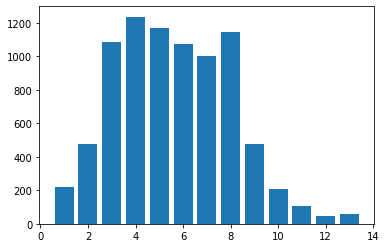

In [ ]:
# 고객 연령 분포
plt.bar(df[['profile_id','age']].drop_duplicates()['age'].value_counts().index, df[['profile_id','age']].drop_duplicates()['age'].value_counts().values)

In [ ]:
d = df[['profile_id','age','views']]
d = d[d['views']==1]

<BarContainer object of 13 artists>

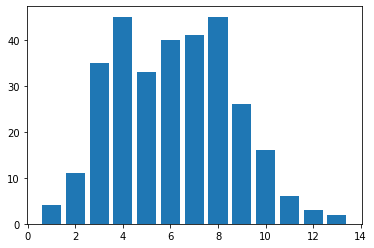

In [ ]:
# view 1짜리 연령 분포
plt.bar(d['age'].value_counts().index, d['age'].value_counts().values)


<BarContainer object of 13 artists>

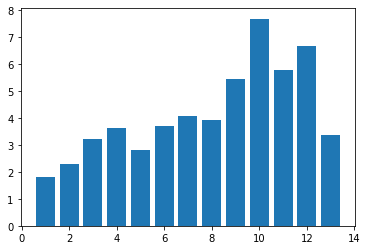

In [ ]:
# 연령 별 view 1짜리 사람의 포션 파악 -> 이탈이 높은 연령대
d_values = d['age'].value_counts().sort_index() / df[['profile_id','age']].drop_duplicates()['age'].value_counts().sort_index() * 100
plt.bar(d_values.index, d_values.values)


view가 1인 경우:  
  해당 고객은 임베딩에서 제외,  
  해당 고객이 봤던 아이템 서칭  
  해당 아이템과 가장 유사한 아이템 체킹해서 추천  

In [ ]:
df['payment'] = df['payment'].fillna(0)
df['payment'] = df['payment'].map(lambda x: 0 if x == 0 else 1)

In [ ]:
data = df[['profile_id','log_time','album_id','views']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
data.shape

(899252, 5)

In [ ]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
# data = df[['profile_id','log_time','album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
# data['rating'] = 1
# data.shape

In [ ]:
d = data[['profile_id','views']].drop_duplicates()
one_views_user = d[d['views']==1]['profile_id'].values

In [ ]:
cfg.n_users = data.profile_id.max()+1#-len(one_views_user)
cfg.n_items = data.album_id.max()+1

In [ ]:
data_new = data.drop(data[data['views']==1].index).reset_index()

In [ ]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data_new, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719156, 6)
검증 데이터 크기: (179789, 6)


In [ ]:
sparse.lil_matrix((cfg.n_users, cfg.n_items))

<33033x25917 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [ ]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (idx, p, _, i, r, view) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/719156 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# 유저 특징 정보 추출 
df = df.set_index('profile_id')
user_features = df[['age']].to_dict()
# # 성별, view, continuous 추가
df['sex'] = df['sex'].map(lambda x: 1 if x == 'M' else 0)
user_features_sex = df[['sex']].to_dict()
user_features_views = df[['views']].to_dict()
print("user_id 3의 age 정보 :", user_features['age'][3])
print("user_id 3의 age 정보 :", user_features_sex['sex'][3])
print("user_id 3의 age 정보 :", user_features_views['views'][3])

user_id 3의 age 정보 : 5
user_id 3의 age 정보 : 0
user_id 3의 age 정보 : 23


In [ ]:
# 아이템 특징 정보 추출 
# meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
# meta['run_time']= meta['run_time'].map(lambda x: np.log10(x)+1)
item_features = meta_df[['genre_mid']].to_dict()
item_features_run = meta_df[['run_time']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])
print("album_id 749의 run_time 정보 :", item_features_run['run_time'][749])

album_id 749의 genre_mid 정보 : 5
album_id 749의 run_time 정보 : 539


In [ ]:
# 검색 상호작용 딕셔너리 생성
search = search[search['album_id']<cfg.n_items]
search_dict = {}
for i in tqdm(search['profile_id'].unique()):
  search_dict[i] = list(search[search['profile_id']== i]['album_id'].values)

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 구매 상호작용 딕셔너리 생성
buy = buy_df[['profile_id','album_id','payment']]
buy_dict = {}
for i in tqdm(buy['profile_id'].unique()):
  buy_dict[i] = list(buy[buy['profile_id']== i]['album_id'].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = df['sex'].nunique()
cfg.n_search = 2
cfg.n_continuous_feats = 4 


In [ ]:
one_views_dict = {}
for user_i, _,album_i,_,_ in np.array(data[data['views']==1]):
  one_views_dict[user_i] = album_i


In [ ]:
meta = pd.merge(metap_df[['album_id','keyword_type','keyword_value']].drop_duplicates(), meta_df.drop(columns = ['sub_title', 'genre_small','onair_date','genre_large','cast_2','cast_3','cast_4','cast_5','cast_6','cast_7']).drop_duplicates(), "left", on='album_id')
meta.shape

(767948, 8)

In [ ]:
keywordss = []
for i in tqdm(meta['album_id'].unique()):
  m = meta[meta['album_id']==i]
  keyword = []
  need_cnt = 3
  key_val = 5
  
  while need_cnt >= 0 and key_val >= 0:
    if key_val in m['keyword_value'].values: # 키워드 가치 점수가 해당 밸류에 있다면,
      m1 = m[m['keyword_value']==key_val]    # 해당 밸류만을 뽑은 데이터프레임 가져오기
      if len(m1['keyword_type'].values) >= need_cnt:    # 만약 개수가 필요한 개수보다 많을 경우
        keyword.extend(m1['keyword_type'].values[:need_cnt])  # 필요한 개수까지만 가져오기
        need_cnt = need_cnt - len(m1['keyword_type'].values[:need_cnt]) # 필요한 개수 업데이트하기
        key_val = key_val - 1                                 # 다음 키워드 가치 점수로 이동
      else:
        keyword.extend(m1['keyword_type'].values)
        need_cnt = need_cnt - len(m1['keyword_type'].values)

    key_val = key_val - 1
  keywordss.append(keyword)
  

  0%|          | 0/39875 [00:00<?, ?it/s]

In [ ]:
meta_new = meta.drop(columns = ['keyword_type', 'keyword_value']).drop_duplicates()
meta_new['keywords'] = keywordss
meta_new = meta_new.sort_values(by = 'album_id')

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'title', 'sub_title',
       'genre_large', 'genre_mid', 'genre_small', 'country', 'run_time',
       'onair_date', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'cast_6', 'cast_7', 'views', 'payment', 'search'],
      dtype='object')

In [ ]:
profile_df

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,P04,NaN,NaN,K04,K08,NaN
8307,33023,M,5,P06,P03,P07,K08,K04,K05
8308,33026,F,8,P01,P03,P08,K05,K09,K06
8309,33027,F,4,P04,P05,P06,K03,K01,K05


In [ ]:
profile_df.pr_interest_keyword_cd_1.value_counts()

P06    1613
P02    1530
P01    1355
P07    1093
P03    1071
P05     779
P04     580
P08     290
Name: pr_interest_keyword_cd_1, dtype: int64

In [ ]:
metap_df.keyword_name.value_counts()[:50]

시리즈             32644
엔터              30040
사회정서            26135
언어1             23611
TV 방영           16553
2분 이상 10분 미만    14018
스토리 애니          13317
동물              13251
4세              12920
5세              12142
자연탐구            11627
EBS             10413
음악              10400
캐릭터 친구들         10246
3세               9812
6세               9442
어린이 예능           9127
친절               8937
7세               8632
특정부분학습           8625
감사               8578
같이하기 (나란히)       7601
음악예술             6494
8세               6309
사랑               6302
노래               5698
노래 따라하기          5663
동요               5612
실험하기             5564
영어유치원            5427
놀이               5404
인지               5128
혼자하기 (혼자)        4927
운동               4830
신나는              4827
과학기술             4711
2세               4532
1세               4522
음식               4422
9세               3826
정서사회             3802
교육               3732
18분 이상           3698
장난감              3648
2분 미만            3540
협동성       

In [ ]:
# 예고편만 있는 것도 있음
history_df[history_df['short_trailer']=='Y']['album_id'].unique()

array([   33,   138,   150, ..., 14665, 14662, 14663])

In [ ]:
meta_age = pd.merge(history_df)

In [ ]:
meta_new

,album_id,title,genre_mid,country,run_time,cast_1,keywords
715606,0,An Amazing Snowman,19,미국,136,NaN,"[050c040a, 050c0e16, 050c0f01]"
356816,1,공이 또르르,19,한국,63,NaN,"[050c0405, 050c0809, 050c0d02]"
356968,2,목도리를 돌돌,19,한국,96,NaN,"[050c040a, 050c0a03, 050c0d02]"
720166,3,Secret Agent Mater,19,미국,125,NaN,"[050c0407, 050c0e27, 050c0f01]"
90202,4,신나는 연날리기 - 네팔,1,NaN,748,NaN,"[05020201, 05070501, 0508041d]"
...,...,...,...,...,...,...,...
767885,39870,로티프렌즈와 색칠놀이! - 로티 ＆ 텐트,5,한국,456,NaN,"[05030702, 05010101, 05010202]"
767892,39871,로티프렌즈와 색칠놀이! - 하트핑 ＆ 비행기,5,한국,468,NaN,"[05030702, 05010101, 05010202]"
767899,39872,로티프렌즈와 색칠놀이! - 캔디코 ＆ 동화책,5,한국,443,NaN,"[05030702, 05010101, 05010202]"
767906,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,5,한국,477,NaN,"[05030702, 05010101, 05010202]"


In [ ]:
# meta_new['cast_1'] = meta_new['cast_1'].fillna('없음')
# meta_new['country'] = meta_new['country'].fillna('알수없음')
# meta_new['features'] = meta_new['genre_mid'].map(lambda x: str(x)) + ' ' + meta_new['country'] +' '+ meta_new['run_time'].map(lambda x: str(x))+' '  + meta_new['cast_1'] + ' ' +meta_new['keywords'].map(lambda x: ' '.join(x))
# # meta_new['features'] = meta_new['country'] +' ' + meta_new['cast_1'] + ' ' +meta_new['keywords'].map(lambda x: ' '.join(x))

In [ ]:
meta_new[meta_new['album_id']<cfg.n_items]['keywords'].map(lambda x: ' '.join(x)).values

array(['05020201 0508042c 0508050a 05010101 05010302',
       '05020201 0508042c 0508050a 05010101 05010302',
       '05020201 0508042c 0508050a 05010101 05010302', ...,
       '05020202 05060102 05070201 0507020f 05010101',
       '05020204 05030604 0509070e 05010102 05010104',
       '05020205 0508042c 05010101 05010201 05020203'], dtype=object)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(min_df=1, ngram_range = (1,1))
df_cnt = tfidf.fit_transform(meta_new[meta_new['album_id']<cfg.n_items]['keywords'].map(lambda x: ' '.join(x)).values)
# a_matrix = pd.DataFrame(df_cnt.todense(), columns = tfidf.get_feature_names())
keyword_embedding = np.array(df_cnt.todense())
keyword_embedding

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.31376758, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31376758, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# 745개 차원으로 키워드 빈도기반으로 임베딩 진행
print(len(keyword_embedding[0]))
cfg.n_keywords = len(keyword_embedding[0])

632


In [ ]:
torch.FloatTensor(keyword_embedding).unsqueeze(1)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.1591, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1615, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1419, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

## DeepFM 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

In [ ]:
torch.cumsum(torch.Tensor([[4,5,10],[6,7,3]])

SyntaxError: ignored

In [ ]:
df

,log_time,album_id,sex,age,title,sub_title,genre_large,genre_mid,genre_small,country,...,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,views,payment,search
profile_id,,,,,,,,,,,,,,,,,,,,,
3,20220301115719,15,0,5,거미,핑크퐁 3D율동동요,키즈,노래율동,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,0,NaN
3,20220301115809,16,0,5,상어 가족,노래율동,키즈,노래율동,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,0,NaN
3,20220301115809,16,0,5,상어 가족,핑크퐁 3D율동동요,키즈,노래율동,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,0,NaN
3,20220301115958,17,0,5,작은 별,핑크퐁 3D율동동요,키즈,노래율동,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,0,NaN
3,20220301120118,18,0,5,작은 주전자에요,만 3세를 위한 영상,키즈,노래율동,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33032,20220427155668,381,0,5,할머니의 용궁여행,6-7세,키즈,책,NaN,한국,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,0,NaN
33032,20220427155680,381,0,5,할머니의 용궁여행,6-7세,키즈,책,NaN,한국,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,0,NaN
33032,20220427155810,125,0,5,응가공주,4-5세,키즈,책,NaN,한국,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,0,NaN


In [ ]:
def data_massage(data,  category_cols, numeric_cols):
    feat_cols = category_cols + numeric_cols
    fields = []
    for feat_col in feat_cols:
        if feat_col not in category_cols:
            fields.append(1)
        else:
            fields.append(data[feat_col].nunique())
    start_idx = [0] + np.cumsum(fields)[:-1].tolist()

    return feat_cols, start_idx, fields

class FMDataset(Dataset):
    def __init__(self, data, feat_start_idx, fields_size, feat_cols, target_col):
        self.data = data
        self.label = np.asarray(self.data[target_col])

        self.feat_cols = feat_cols
        self.fields = fields_size
        self.start_idx = feat_start_idx

    def __getitem__(self, index):
        row = self.data.loc[index, self.feat_cols]
        idxs = list()
        vals = list()
        # label = self.data.loc[index, self.]
        label = self.label[index]
        for i in range(len(row)):
            if self.fields[i] == 1:
                idxs.append(self.start_idx[i])
                vals.append(row[i])
            else:
                idxs.append(int(self.start_idx[i] + row[i]))
                vals.append(1)

        label = torch.tensor(label, dtype=torch.float32)
        idxs = torch.tensor(idxs, dtype=torch.long)
        vals = torch.tensor(vals, dtype=torch.float32)
        
        return label, idxs, vals

    def __len__(self):
        return len(self.data)

feat_cols, feat_start_idx, fields_size = data_massage(data,  category_cols, numeric_cols)

args = {
    'batch_size': 256,
    'gpuid': '0',
    'lr': 0.001,
    'l2_reg': 0.,
    'epochs': 15,
    'num_features': len(feat_cols),
    'embedding_dim': 8,
    'field_size': fields_size,
    'dense_size': [32, 32],
    '1o_dropout_p': 1., 
    '2o_dropout_p': 1., 
    'deep_dropout_p': 0.5,
    'batch_norm': True,
    'deep_layer_act': 'relu',
    'opt_name': 'adam'
}

train_data, test_data = train_test_split(data, test_size=0.2)
train_data, test_data = train_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_dataset = FMDataset(train_data, feat_start_idx, fields_size, feat_cols, target_col)
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)

test_dataset = FMDataset(test_data, feat_start_idx, fields_size, feat_cols, target_col)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

model = DeepFM(args)
model.fit(train_loader)
model.predict(test_loader)

In [ ]:
from multiprocessing.sharedctypes import Value
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# torch.random.manual_seed(2022)

class DeepFM(nn.Module):
    def __init__(self, args) -> None:
        super(DeepFM, self).__init__()
        # 쿠다환경 설정
        os.environ['CUDA_VISIBLE_DEVICES'] = args['gpuid']

        self.lr = args['lr']            # 정규화 설정    
        self.l2_reg = args['l2_reg']    # 정규화 설정
        self.epochs = args['epochs']    # 에폭 설정

        self.num_fetures = args['num_features']   # feature tn
        self.emb_dim = args['embedding_dim']      # 임베딩 차원
        self.feature_embs = nn.Embedding(sum(args['field_size']), args['embedding_dim'])  # 특성 임베딩
        self.bias_embs = nn.Embedding(sum(args['field_size']), 1) # 바이어스 임베딩

        # self.num_layers = args['num_layers'] # 2
        self.deep_neurons = args['dense_size']  # 뉴런 사이즈
        self.early_stop = True                  # 얼리스타핑
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # GPU사용
        self.batch_norm = args['batch_norm']  # 배치 정규화
        self.opt = args['opt_name']           # 옵티마이저 

        if args['deep_layer_act'] == 'relu':  # 활성함수    
            self.deep_layer_act = nn.ReLU()
        else:
            raise ValueError('Invalid activation function name for deep layers')

        self.dropout_fm_1o = nn.Dropout(p=args['1o_dropout_p']) # 드롭아웃
        self.dropout_fm_2o = nn.Dropout(p=args['2o_dropout_p']) # 드롭아웃

        deep_modules = []
        layers_size = [self.num_fetures * self.emb_dim] + args['dense_size']  # [특성 수 * 차원 수] + 덴스 사이즈 -> 확인필요
        
        # 레이어 생성 
        for in_size, out_size in zip(layers_size[:-1], layers_size[1:]):      
            deep_modules.append(nn.Linear(in_size, out_size))
            if self.batch_norm:
                deep_modules.append(nn.BatchNorm1d(num_features=out_size))
            deep_modules.append(self.deep_layer_act)
            deep_modules.append(nn.Dropout(p=args['deep_dropout_p']))
        
        self.deep = nn.Sequential(*deep_modules)

        self.output = nn.Linear(args['dense_size'][-1] + self.num_fetures + self.emb_dim, 1, bias=False) # concat projection

        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.feature_embs.weight, std=0.01)

        glorot = np.sqrt(2.0 / (self.num_fetures * self.emb_dim + self.deep_neurons[0]))

        for la in self.deep:
            if isinstance(la, nn.Linear):
                nn.init.normal_(la.weight, std=glorot)
                nn.init.constant_(la.bias, 0.)
                glorot = np.sqrt(2.0 / (la.weight.size()[0] + la.weight.size()[1]))

        glorot = np.sqrt(2.0 / (self.deep_neurons[-1] + self.num_fetures + self.emb_dim + 1))
        nn.init.normal_(self.output.weight, std=glorot)

    def forward(self, idxs, vals): # idx/vals: batchsize * feature_size
        feat_emb = self.feature_embs(idxs)  # batch_size * feature_size * embedding_size

        # reshape으로 val 사이즈를 feat_emb와 차원수를 맞춘 뒤 expand로 차원을 변경한 뒤 emb_dim으로 변경해 element wise product w/ feat_emb
        feat_emb = torch.multiply(feat_emb, torch.reshape(vals, [feat_emb.size(0), feat_emb.size(1), 1]).expand([feat_emb.size(0), feat_emb.size(1), self.emb_dim])) # batch_size * feature_size * embedding_size
        # first order part
        y_first_order = self.bias_embs(idxs) # 바이어스 임베딩 batch_size * feature_size * 1 
        y_first_order = torch.multiply(y_first_order, torch.reshape(vals, [feat_emb.size(0), feat_emb.size(1), 1])) # 바이어스, val element wise batch_size * feature_size * 1
        y_first_order = torch.sum(y_first_order, dim=2) # batch_size * feature_size, 모든 수치 값 합산
        y_first_order = self.dropout_fm_1o(y_first_order) # batch_size * feature_size
        # second order part
        summed_features_emb = torch.sum(feat_emb, 1)  # 기존 feat_emb +1, batch_size * embedding_size
        summed_features_emb_square = torch.square(summed_features_emb) # 위의 것 제곱, batch_size * embedding_size
        squared_features_emb = torch.square(feat_emb)  # 원래 것 제곱, batch_size * feature_size * embedding_size
        squared_sum_features_emb = torch.sum(squared_features_emb, 1)  #위의 것 제곱에 1더하기, batch_size * embedding_size
        y_second_order = 0.5 * torch.subtract(summed_features_emb_square, squared_sum_features_emb) # 위의것 제곱 - 기존 것 제곱batch_size * embedding_size
        y_second_order = self.dropout_fm_2o(y_second_order) # batch_size * embedding_size
        # deep part
        y_deep = feat_emb.view(feat_emb.size(0), -1) # batch_size * (feature_size * embedding_size)
        y_deep = self.deep(y_deep)
        
        concat_input = torch.cat([y_first_order, y_second_order, y_deep], dim=1) # batchsize * (embedding_size+feature_size+last_layer_out_size)
        output = self.output(concat_input)   # batch_size * 1
        out = torch.sigmoid(output)

        return out.view(-1)

    def fit(self, train_loader, valid_loader=None):
        if torch.cuda.is_available():
            self.cuda()
        else:
            self.cpu()
        if self.opt == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=self.lr)
        elif self.opt == 'adagrad':
            optimizer = optim.Adagrad(self.parameters(), lr=self.lr)
        elif self.opt == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError(f'Invalid optimizer name: {self.opt}')

        criterion = nn.BCEWithLogitsLoss(reduction='sum') # CE_log_loss for binary classification
        
        last_loss = 0.
        for epoch in range(1, self.epochs + 1):
            self.train()
            current_loss = 0.
            total_sample_num = 0
            for labels, idxs, vals in train_loader:
                total_sample_num += labels.size()[0]
                if torch.cuda.is_available():
                    labels = labels.cuda()
                    idxs = idxs.cuda()
                    vals = vals.cuda()
                else:
                    labels = labels.cpu()
                    idxs = idxs.cpu()
                    vals = vals.cpu()
                self.zero_grad()
                # TODO remember to let batches in loader put on GPU or CPU
                prediction = self.forward(idxs, vals)
                loss = criterion(prediction, labels)
                loss += self.l2_reg * self.output.weight.norm()
                for la in self.deep:
                    if isinstance(la, nn.Linear):
                        loss += self.l2_reg * la.weight.norm()
                if torch.isnan(loss):
                    raise ValueError(f'Loss=Nan or Infinity: current settings does not fit the recommender')
                
                loss.backward()
                optimizer.step()
                current_loss += loss.item()

            print(f'[Epoch {epoch:03d}] - training loss={current_loss / total_sample_num:.4f}')
            delta_loss = float(current_loss - last_loss)
            if (abs(delta_loss) < 1e-5) and self.early_stop:
                print('Satisfy early stop mechanism')
                break
            else:
                last_loss = current_loss

            if valid_loader is not None:
                self.eval()
                # TODO if need valdiation
                pass

    def predict(self, test_loader):
        self.eval()
        _, idxs, vals = next(iter(test_loader))
        idxs = idxs.to(self.device)
        vals = vals.to(self.device)
        preds = self.forward(idxs, vals).cpu().detach()

        return preds

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
nn.Linear(2*cfg.emb_dim + cfg.n_genres//2 + cfg.n_sex//2 + cfg.n_search//2 + 1  + cfg.n_continuous_feats, cfg.layer_dim)

Linear(in_features=533, out_features=256, bias=True)

In [ ]:
nn.Linear(cfg.layer_dim, cfg.layer_dim//2)

Linear(in_features=256, out_features=128, bias=True)

In [ ]:
embedding_layer = nn.Embedding(len(keyword_embedding), embedding_dim = 256)
embedding_layer.weight[]

IndexError: ignored

In [ ]:
keyword_embedding.shape


(25917, 632)

In [ ]:
senom = []
emb = nn.Embedding(num_embeddings=632, embedding_dim = 1)
z = emb(torch.FloatTensor(keyword_embedding).to(torch.int64)).squeeze(2)

In [ ]:
profile_df['profile_id'].unique()[:40]

array([  3,   5,   7,  12,  16,  19,  20,  22,  24,  26,  27,  30,  31,
        33,  35,  55,  56,  59,  62,  63,  66,  68,  74,  77,  80,  89,
        94,  96, 101, 102, 103, 109, 110, 115, 116, 118, 121, 122, 124,
       127])

In [ ]:
# senom_genre = []
# senom_run = []
senom_key = []
for i in range(3,8):
  # senom_genre.extend(UIdataset[i][3].tolist())
  # senom_run.extend(UIdataset[i][4].tolist())
  senom_key.extend(UIdataset[i][8])

In [ ]:
print(len(senom_genre))
print(len(senom_run))
print(len(senom_key[:7070]))

27674
27674
7070


In [ ]:
g_emb = nn.Embedding(cfg.n_genres, cfg.n_genres//2).cuda()

In [ ]:
g_emb

Embedding(29, 14)

In [ ]:
k_emb = nn.Embedding(3, 1).cuda()

In [ ]:
s_key = []
UIdataset[3][8]
print(len(s_key))

1616


In [ ]:
t_key = torch.FloatTensor(senom_key[:7070]).to(cfg.device)
print(t_key.shape)
print(t_key)

torch.Size([7070, 632])
tensor([[0.2661, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2661, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2661, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2325, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')


In [ ]:
t_genre = torch.LongTensor(senom_genre).to(cfg.device)
print(t_genre.shape)
print(t_genre)
print(g_emb(t_genre))
print(g_emb(t_genre))

torch.Size([27674])
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')
tensor([[-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989],
        [-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989],
        [-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989],
        ...,
        [-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989],
        [-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989],
        [-1.3194, -0.0713,  0.2685,  ..., -0.0118,  0.5236, -0.5989]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
torch.Size([27674, 14])


In [ ]:
t_run = torch.FloatTensor(senom_run).to(cfg.device)
print(t_run.shape)
print(t_run)
print(t_run.unsqueeze(1))
print(t_run.unsqueeze(1).shape)

torch.Size([27674])
tensor([1., 1., 1.,  ..., 1., 4., 5.], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [4.],
        [5.]], device='cuda:0')
torch.Size([27674, 1])


In [ ]:
model4.train()
curr_loss_avg = 0.0

user_indices = np.arange(cfg.n_users)
np.random.RandomState(cfg.epoch).shuffle(user_indices)

batch_num = int(len(user_indices) / cfg.batch_size) + 1
bar = tqdm(range(batch_num), leave=False)
for step, batch_idx in enumerate(bar):
    feat3, feat4,feat7= batches(user_indices, batch_idx, cfg.batch_size)
    # 배치 사용자 단위로 학습

    feat4 = torch.FloatTensor(feat4).to(cfg.device)
    feat5 = torch.LongTensor(feat5).to(cfg.device)
    feat6 = torch.FloatTensor(feat6).to(cfg.device)
    feat7 = torch.FloatTensor(feat7).to(cfg.device)
    labels = torch.FloatTensor(labels).to(cfg.device)
    labels = labels.view(-1, 1)

    # grad 초기화
    optimizer.zero_grad()

    # 모델 forward
    genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)

In [ ]:
def batches(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_feat3 = []  # genre
    batch_feat4 = []  # runtime
    batch_feat7 = []  # keyword

    for user_id in batch_user_indices:
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        feat7 = UIdataset[user_id][8] 

        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())      
        batch_feat7.extend(feat7)
    return batch_feat3, batch_feat4,batch_feat7

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

In [ ]:
senom_key

AttributeError: ignored

In [ ]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(input_dim, embed_dim))
            layers.append(torch.nn.ReLU(input_dim, embed_dim))
            layers.append(torch.nn.Dropout(input_dim, embed_dim))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)
    def forward(self, x):
        """
        파라미터 x: Float 텐서 사이즈. ''(Batch_size, embed_dim)''
        """
        return self.mlp(x)



class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_keywords = cfg.n_keywords
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex
        self.n_search = cfg.n_search
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # mf용 유저임베딩 - 유저 임베딩 수 == 유저 cfg 수, 임베딩 차원 수 == 256 
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        # mlp 용 유저 임베딩, 차원 수도 동일한 방법
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        # mlp 용 특성 장르 임베딩도 설정
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        # mlp 용 특성 성별 임베딩도 설정
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex//2)
        # mlp 용 특성 search 임베딩 설정
        self.search_embedding = nn.Embedding(num_embeddings=self.n_search, embedding_dim=self.n_search//2)
        # mlp 용 특성 keyword 임베딩 설정
        # self.keyword_embedding_mlp = nn.Embedding(num_embeddings= self.n_keywords, embedding_dim = 1)
      
        # mlp 레이어 - 시퀜셜 모델로 생성
        self.mlp_layers = nn.Sequential(
            # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_sex//2 + self.n_keywords + self.n_search//2 + self.n_continuous_feats , self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2),
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        # 임베딩 진행
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[3])

        
        #성별 임베딩 추가
        sex_embedding_mlp = self.sex_embeddig(feats[2])

        #검색여부 임베딩 추가
        search_embedding_mlp = self.search_embedding(feats[5])

        #키워드 임베딩 추가
        # keyword_embedding_mlp = self.keyword_embedding_mlp(feats[7].to(torch.int64))
        # print(feats[7].squeeze(0).shape)
        # print(feats[0])
        # print(feats[1])
        # print(feats[2].unsqueeze(1).shape)
        # print(feats[4].unsqueeze(1).shape)
        # print(feats[6].unsqueeze(1).shape)
        # print(genre_embedding_mlp.shape)
        # print(sex_embedding_mlp.shape)
        # # print(keyword_embedding_mlp.shape)
        # print('-----------------------------------------')
        # print(user_embedding_mf)
        # print(item_embedding_mf)
        # print(genre_embedding_mlp)         
        # # print(search_embedding_mlp)
        # # print(keyword_embedding_mlp.unsqueeze(1).shape)
        # # print(keyword_embedding_mlp.unsqueeze(1))
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp,sex_embedding_mlp, search_embedding_mlp, feats[0].unsqueeze(1), feats[1].unsqueeze(1),feats[4].unsqueeze(1), feats[6].unsqueeze(1), feats[7]),  -1)
        # print(input_feature.shape)
        # print(input_feature)
        # print(input_feature.shape[0])
        if input_feature.shape[0] != 0:
          mlp_output = self.mlp_layers(input_feature)
          output = torch.cat([mlp_output, mf_output], dim=-1)
          output = self.affine_output(output).squeeze(-1)
          return output
        else:
          pass
        

NameError: ignored

In [ ]:
keyword_embedding.shape

(25917, 745)

In [ ]:
torch.FloatTensor(keyword_embedding).shape

torch.Size([25917, 745])

In [ ]:
keyword_embedding

array([[0.1573515 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1573515 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1573515 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.12560867, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34333232, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18219741, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [ ]:
keyword_embedding[3]

In [ ]:
from pandas.core.indexes.period import parse_time_string
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):

      UIdataset[user_id] = []
      # positive 샘플 계산 
      # pos item은 0.5 이상인 것들의 index를 찾아 출력
      pos_item_ids = np.where(items_by_user > 0.5)[0]
      # pos 샘플 개수
      num_pos_samples = len(pos_item_ids)

      # negative 샘플 계산 (random negative sampling)
      # neg 샘플 개수 
      num_neg_samples = neg_ratio * num_pos_samples
      neg_items = np.where(items_by_user < 0.5)[0]
      # neg 샘플 중 랜덤 초이스
      neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
      # pos, neg 샘플 짝지어서 UIdataset에 넣기
      UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
      
      # feature 추출 
      features_age = []
      features_views = []
      features_sex = []
      # pos, neg 쌍을 하나씩 뽑고,
      for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
          # user_features의 user에 따른 나이를 features에 넣기
          features_age.append(user_features['age'][user_id])  # float
          features_views.append(user_features_views['views'][user_id])  # float
          features_sex.append(user_features_sex['sex'][user_id])  # long
      #나이 정보 순서를 append해서 모든 쌍에 추가해주기
      UIdataset[user_id].append(np.array(features_age))
      UIdataset[user_id].append(np.array(features_views))
      UIdataset[user_id].append(np.array(features_sex))

      features_genre = []
      features_run = []
      features_search = []
      features_payment = []
      features_keywords = []
      # pos와 neg 일렬 리스트로 변환
      for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
          # item_features의 item에 따른 장르를 features에 넣기

          features_genre.append(item_features['genre_mid'][item_id])  # long
          features_run.append(item_features_run['run_time'][item_id]) # float
          features_keywords.append(keyword_embedding[item_id])
          if user_id in search_dict.keys():
            if item_id in search_dict[user_id]:
              features_search.append(1)
            else:
              features_search.append(0)
          else:
            features_search.append(0)
          if user_id in buy_dict.keys():
            if item_id in buy_dict[user_id]:
              features_payment.append(int(buy[(buy['profile_id']==user_id)&(buy['album_id']==item_id)]['payment'].values[0]))
            else:
              features_payment.append(0)
          else: 
            features_payment.append(0)
          

      #장르 정보를 append해서 모든 쌍에 추가해주기 -> 상호작용에 feature가 추가된것임
      UIdataset[user_id].append(np.array(features_genre))
      UIdataset[user_id].append(np.array(features_run))
      UIdataset[user_id].append(np.array(features_search))
      UIdataset[user_id].append(np.array(features_payment))
      if len(features_keywords) == 0:
        UIdataset[user_id].append(np.array(features_keywords))
      else:
        UIdataset[user_id].append(features_keywords)
      # label 저장  
      pos_labels = np.ones(len(pos_item_ids))
      neg_labels = np.zeros(len(neg_item_ids))
      UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [ ]:
keyword_embedding[3]

In [ ]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [ ]:
UIdataset[0]

[array([], dtype=int64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [ ]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []  # age
    batch_feat1 = []  # views
    batch_feat2 = []  # sex 
    batch_feat3 = []  # genre
    batch_feat4 = []  # runtime
    batch_feat5 = []  # runtime
    batch_feat6 = []  # runtime
    batch_feat7 = []  # keyword
    batch_labels = [] # label
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        feat2 = UIdataset[user_id][3]
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        feat5 = UIdataset[user_id][6]
        feat6 = UIdataset[user_id][7]                
        feat7 = UIdataset[user_id][8] 
        labels = UIdataset[user_id][9]
        user_ids = np.full(len(item_ids), user_id)  # 모든 값을 user_id로 통일
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())      
        batch_feat5.extend(feat5.tolist())   
        batch_feat6.extend(feat6.tolist())   
        batch_feat7.extend(feat7)
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4,batch_feat5, batch_feat6,  batch_feat7, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [ ]:
nn.Linear(cfg.layer_dim//2 + cfg.emb_dim, 1)

Linear(in_features=384, out_features=1, bias=True)

In [ ]:
# def init_weights(module):
#     if isinstance(module, nn.Embedding):
#         normal_(module.weight.data, mean=0.0, std=0.01)
#     elif isinstance(module, nn.Linear):
#         normal_(module.weight.data, 0, 0.01)
#         if module.bias is not None:
#             module.bias.data.fill_(0.0)
# for s, bat in enumerate(tqdm(range(int(len(np.arange(cfg.n_users)) / cfg.batch_size) + 1), leave = False)):
#   user_ids, item_ids, feat0, feat1,feat2, feat3, feat4,feat5, feat6, feat7, labels = make_batchdata(np.arange(cfg.n_users), bat, cfg.batch_size)
#   user_ids = torch.LongTensor(user_ids).to(cfg.device)
#   item_ids = torch.LongTensor(item_ids).to(cfg.device)
#   feat0 = torch.FloatTensor(feat0).to(cfg.device)
#   feat1 = torch.FloatTensor(feat1).to(cfg.device)
#   feat2 = torch.LongTensor(feat2).to(cfg.device)
#   feat3 = torch.LongTensor(feat3).to(cfg.device)
#   feat4 = torch.FloatTensor(feat4).to(cfg.device)
#   feat5 = torch.LongTensor(feat5).to(cfg.device)
#   feat6 = torch.FloatTensor(feat6).to(cfg.device)
#   feat7 = torch.FloatTensor(feat7).to(cfg.device)
#   labels = torch.FloatTensor(labels).to(cfg.device)
#   labels = labels.view(-1, 1)
#   optimizer.zero_grad()

#   user_embedding_mf = nn.Embedding(num_embeddings=cfg.n_users, embedding_dim=cfg.emb_dim)
#   item_embedding_mf = nn.Embedding(num_embeddings=cfg.n_items, embedding_dim=cfg.emb_dim)
  
#   # mlp 용 유저 임베딩, 차원 수도 동일한 방법
#   user_embedding_mlp = nn.Embedding(num_embeddings=cfg.n_users, embedding_dim=cfg.emb_dim)
#   item_embedding_mlp = nn.Embedding(num_embeddings=cfg.n_items, embedding_dim=cfg.emb_dim)
          
#   # mlp 용 특성 장르 임베딩도 설정
#   genre_embeddig = nn.Embedding(num_embeddings=cfg.n_genres, embedding_dim=cfg.n_genres//2)
#   # mlp 용 특성 성별 임베딩도 설정
#   sex_embeddig = nn.Embedding(num_embeddings=cfg.n_sex, embedding_dim=cfg.n_sex//2)
#   # mlp 용 특성 search 임베딩 설정
#   search_embedding = nn.Embedding(num_embeddings=cfg.n_search, embedding_dim=cfg.n_search//2)
#   # mlp 용 특성 keyword 임베딩 설정


#   # mlp 레이어 - 시퀜셜 모델로 생성
#   mlp_layers = nn.Sequential(
#       # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
#       nn.Linear(2*cfg.emb_dim + cfg.n_genres//2 + cfg.n_sex//2 + cfg.n_search//2 + 1 + cfg.n_continuous_feats, cfg.layer_dim), 
#       nn.ReLU(), 
#       nn.Dropout(p=cfg.dropout), 
#       nn.Linear(cfg.layer_dim, cfg.layer_dim//2), 
#       nn.ReLU(), 
#       nn.Dropout(p=cfg.dropout)
#   )
#   feats = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7]
#   affine_output = nn.Linear(cfg.layer_dim//2 + cfg.emb_dim, 1)
#   # self.apply(self._init_weights)])
#   # 임베딩 진행
#   print('여기1')
#   # user_embedding_mf1 = user_embedding_mf(user_ids.cuda())
#   # item_embedding_mf1 = item_embedding_mf(item_ids.cuda())
#   # mf_output = torch.mul(user_embedding_mf1, item_embedding_mf1)
  
#   # user_embedding_mlp1 = user_embedding_mlp(user_ids.cuda())
#   # item_embedding_mlp1 = item_embedding_mlp(item_ids.cuda())
#   genre_embedding_mlp1 = genre_embeddig(feats[3]).cuda()
#   #성별 임베딩 추가
#   sex_embedding_mlp1 = sex_embeddig(feats[2]).cuda()
#   #검색여부 임베딩 추가
#   search_embedding_mlp1 = search_embedding(feats[5]).cuda()
#   #키워드 임베딩 추가
#   print('여기')
#   keyword_embedding_mlp1 = feats[7].cuda()
#   input_feature = torch.cat((user_embedding_mlp1, item_embedding_mlp1, genre_embedding_mlp1, sex_embedding_mlp1, search_embedding_mlp1, keyword_embedding_mlp1, feats[0].unsqueeze(1), feats[1].unsqueeze(1),feats[4].unsqueeze(1), feats[6].unsqueeze(1)), -1)
#   mlp_output = mlp_layers(input_feature)
  
#   output = torch.cat([mlp_output, mf_output], dim=-1)
#   output = affine_output(output).squeeze(-1)


#   output = output.view(-1, 1)
#   break

AttributeError: ignored

In [ ]:
range(int(len(np.arange(cfg.n_users)) / cfg.batch_size) + 1)

range(0, 130)

In [ ]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    

    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1,feat2, feat3, feat4,feat5, feat6, feat7, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.FloatTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.FloatTensor(feat4).to(cfg.device)
        feat5 = torch.LongTensor(feat5).to(cfg.device)
        feat6 = torch.FloatTensor(feat6).to(cfg.device)
        feat7 = torch.FloatTensor(feat7).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7])
        if output is not None:
          output = output.view(-1, 1)

          loss = criterion(output, labels)

          # 역전파
          loss.backward()

          # 최적화
          optimizer.step()    
          if torch.isnan(loss):
              print('Loss NAN. Train finish.')
              break
          curr_loss_avg = update_avg(curr_loss_avg, loss, step)
          
          msg = f"epoch: {cfg.epoch}, "
          msg += f"loss: {curr_loss_avg.item():.5f}, "
          msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
          bar.set_description(msg)
        else:
          pass
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [ ]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [ ]:
query_user_ids = df.reset_index()['profile_id'].unique()

In [ ]:
full_item_ids = np.array([c for c in range(cfg.n_items)])
full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]

키워드 5개까지의 album_id는 제외하고 정리한다.

In [ ]:
meta_keyword_cnt = pd.DataFrame(meta.groupby('album_id')['keyword_name'].count()).reset_index()
meta_under_five_idx = meta_keyword_cnt[meta_keyword_cnt['keyword_name']<=5]['keyword_name'].index

In [ ]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    # full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]
    # cnt = CountVectorizer(min_df=1, ngram_range = (1,1))
    # df_cnt = cnt.fit_transform(meta_new[meta_new['album_id']<cfg.n_items]['features'].values)
    # a_matrix = pd.DataFrame(df_cnt.todense(), columns = cnt.get_feature_names())
    for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
          user_ids = np.full(cfg.n_items, user_id)
          
          user_ids = torch.LongTensor(user_ids).to(cfg.device)
          item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
          
          feat0 = np.full(cfg.n_items, user_features['age'][user_id])
          feat0 = torch.FloatTensor(feat0).to(cfg.device)
          feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
          feat1 = torch.FloatTensor(feat1).to(cfg.device)
          feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
          feat2 = torch.LongTensor(feat2).to(cfg.device)
          feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
          feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
          # detach로 validation set에 대한 그래프 history 차단 후 inference
          feat5 = np.zeros(cfg.n_items)
          if user_id in search_dict.keys():
            np.put(feat5, search_dict[user_id], 1)
          feat5 = torch.LongTensor(feat5).to(cfg.device)           
          feat6 = np.zeros(cfg.n_items)
          if user_id in buy_dict.keys():
            np.put(feat6, buy_dict[user_id], buy[(buy['profile_id']==user_id)&(buy['album_id']==buy_dict[user_id][0])]['payment'].values[0])
          feat6 = torch.FloatTensor(feat6).to(cfg.device)
          feat7_lst = keyword_embedding
          feat7 = torch.FloatTensor(feat7_lst).to(cfg.device)
          eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7]).detach().cpu().numpy()
          pred_u_score = eval_output.reshape(-1)   
        

        pred_u_idx = np.argsort(pred_u_score)[::-1]         # 최종 스코어 높은 순서대로 인덱스 뽑기
          
        pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중에서 스코어가 높은 인덱스들 뽑아 리스트 가져오기

        pred_list.append(list(pred_u[:cfg.top_k]))          # top_k개 만큼을 pred_list에 넣기

    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [ ]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 15
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [ ]:
# model 생성 및 optimizer, loss 함수 설정 
model4 = NeuMF(cfg).to(cfg.device)
# optimizer = torch.optim.Adam(model4.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
# criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
# total_logs = defaultdict(list)
# best_scores  = 0
# for epoch in range(cfg.epochs+1):
#     cfg.epoch = epoch
#     train_results = train_epoch(cfg, model2, optimizer, criterion)
    
#     # cfg.check_epoch 번의 epoch 마다 성능 확인 
#     if epoch % cfg.check_epoch == 0: 
#         valid_results, _ = valid_epoch(cfg, model2, valid)

#         logs = {
#             'Train Loss': train_results['losses'],
#             f'Valid Recall@{cfg.top_k}': valid_results['recall'],
#             f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
#             'Valid Coverage': valid_results['coverage'],
#             'Valid Score': valid_results['score'],
#             }

#         # 검증 성능 확인 
#         for key, value in logs.items():
#             total_logs[key].append(value)

#         if epoch == 0:
#             print("Epoch", end=",")
#             print(",".join(logs.keys()))

#         print(f"{epoch:02d}  ", end="")
#         print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
#         # 가장 성능이 좋은 가중치 파일을 저장 
#         if best_scores <= valid_results['score']: 
#             best_scores = valid_results['score']
#             torch.save(model2.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model2(best_scores).pth'))

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  19011.474610  0.149885  0.108928  0.002606  0.139646


  0%|          | 0/128 [00:00<?, ?it/s]

01  10569.329100  0.211889  0.172503  0.005680  0.202042


  0%|          | 0/128 [00:00<?, ?it/s]

02  8581.365230  0.360879  0.271314  0.053988  0.338487


  0%|          | 0/128 [00:00<?, ?it/s]

03  6411.982420  0.444538  0.329566  0.122342  0.415795


  0%|          | 0/128 [00:00<?, ?it/s]

04  4574.665040  0.484208  0.353238  0.206798  0.451465


  0%|          | 0/128 [00:00<?, ?it/s]

05  3140.543460  0.498272  0.361769  0.261842  0.464146


  0%|          | 0/128 [00:00<?, ?it/s]

06  2210.957520  0.499902  0.361046  0.299728  0.465188


  0%|          | 0/128 [00:00<?, ?it/s]

07  1423.721680  0.503949  0.361180  0.333834  0.468257


  0%|          | 0/128 [00:00<?, ?it/s]

08  1024.000610  0.504027  0.362968  0.327684  0.468762


  0%|          | 0/128 [00:00<?, ?it/s]

09  703.090390  0.504017  0.362457  0.340430  0.468627


  0%|          | 0/128 [00:00<?, ?it/s]

10  529.968320  0.503218  0.360764  0.336721  0.467604


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model4, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model4, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))

        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model4.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model4(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  19356.857420  0.144370  0.095012  0.002629  0.132031


  0%|          | 0/130 [00:00<?, ?it/s]

01  11137.689450  0.202899  0.142317  0.006244  0.187754


  0%|          | 0/130 [00:00<?, ?it/s]

02  9062.648440  0.344544  0.224899  0.057978  0.314632


  0%|          | 0/130 [00:00<?, ?it/s]

03  7023.002930  0.421572  0.269270  0.116966  0.383497


  0%|          | 0/130 [00:00<?, ?it/s]

04  4958.483890  0.460036  0.288649  0.185907  0.417189


  0%|          | 0/130 [00:00<?, ?it/s]

05  3386.276610  0.475910  0.293053  0.254166  0.430196


  0%|          | 0/130 [00:00<?, ?it/s]

06  2371.107910  0.480053  0.296045  0.298671  0.434051


  0%|          | 0/130 [00:00<?, ?it/s]

07  1522.747680  0.481796  0.297011  0.307943  0.435600


  0%|          | 0/130 [00:00<?, ?it/s]

08  1088.206420  0.483083  0.298626  0.327848  0.436969


  0%|          | 0/130 [00:00<?, ?it/s]

09  803.042790  0.481034  0.297806  0.319398  0.435227


  0%|          | 0/130 [00:00<?, ?it/s]

10  571.641970  0.480574  0.297446  0.329257  0.434792


  0%|          | 0/130 [00:00<?, ?it/s]

11  405.546880  0.483535  0.298870  0.329163  0.437369


  0%|          | 0/130 [00:00<?, ?it/s]

### 학습 과정 시각화

In [ ]:
keyword_embedding.shape

(25917, 745)

In [ ]:
nn.Linear(2*cfg.emb_dim + cfg.n_genres//2 + cfg.n_sex//2 + cfg.n_search//2 + 1 + cfg.n_continuous_feats, cfg.layer_dim), 

(Linear(in_features=533, out_features=256, bias=True),)

In [ ]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

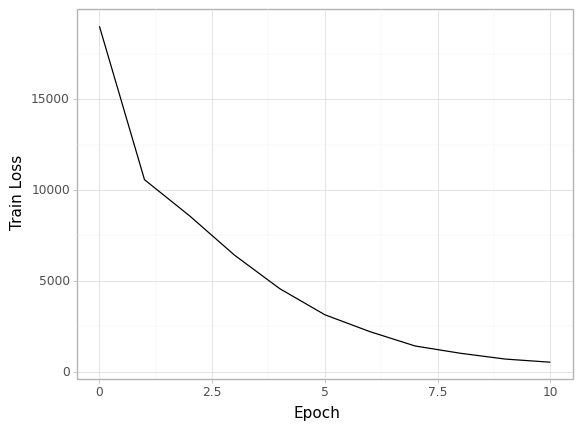

<ggplot: (8759938917877)>

In [ ]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))+ geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [ ]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

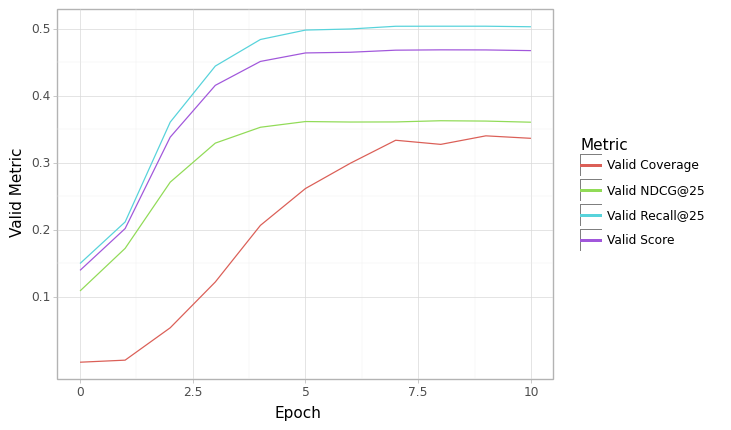

<ggplot: (8760290489593)>

In [ ]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [ ]:
model4.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/code/saved', 'model4(best_scores).pth')))

<All keys matched successfully>

In [ ]:
meta[meta['album_id']==34453]

In [ ]:
submission_path = os.path.join('/content/drive/MyDrive/data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model4, submission, mode='test')

### 저장

In [ ]:
submission.to_csv(os.path.join('/content/drive/MyDrive/data', 'submission_keyword1.csv'), index = False)

In [ ]:
valid.shape

(179851, 4)

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'title', 'sub_title',
       'genre_large', 'genre_mid', 'genre_small', 'country', 'run_time',
       'onair_date', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'cast_6', 'cast_7', 'views'],
      dtype='object')

In [ ]:
valid_df = pd.merge(valid, df[['profile_id','views']], "left", on = 'profile_id')
valid_df.shape

In [ ]:
val_pred = valid_epoch(cfg, model, valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(val_pred)